In [1]:
import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.viz import circular_layout
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Split data - Make events

In [18]:
# read one sample data
mne_filename = "mne_data/C10_32Ch_48Subjects_al_raw_eeg.fif"
raw = mne.io.read_raw_fif(mne_filename, verbose=False)

In [19]:
events = mne.make_fixed_length_events(raw, start=0, stop=20, duration=2., overlap=1.75, id = 1)

# forward solution

In [2]:
import os
import numpy as np

# Download fsaverage files
fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)

# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = os.path.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = os.path.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

0 files missing from root.txt in C:\Users\work\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage


Using surface: C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage\bem\inner_skull.surf
Using surface: C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage\bem\outer_skull.surf
Using surface: C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage\bem\outer_skin.surf


c:\Users\work\Anaconda3\envs\kia\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


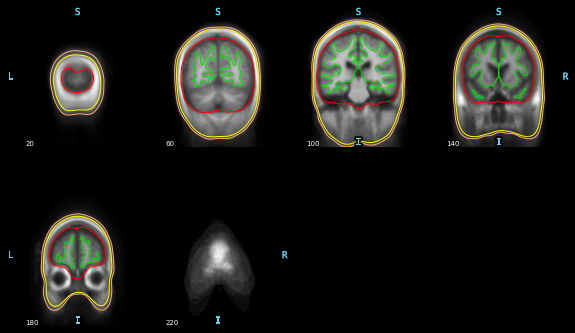

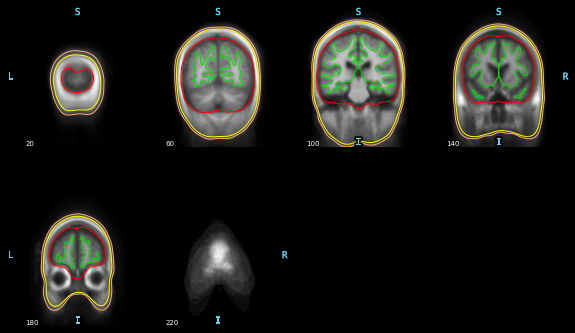

In [24]:
plot_bem_kwargs = dict(
    subject=subject, subjects_dir=subjects_dir,
    brain_surfaces='white', orientation='coronal',
    # slices=[50, 100, 150, 200],
    slices=[20, 60, 100, 140, 180, 220],
    )

mne.viz.plot_bem(**plot_bem_kwargs)

In [4]:
# Clean channel names to be able to use a standard 1005 montage
new_names = dict(
    (ch_name,
     ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp'))
    for ch_name in raw.ch_names)
raw.rename_channels(new_names)

# Read and set the EEG electrode locations, which are already in fsaverage's
# space (MNI space) for standard_1020:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)
raw.set_eeg_reference(projection=True)  # needed for inverse modeling

# Check that the locations of EEG electrodes is correct with respect to MRI
mne.viz.plot_alignment(
    raw.info, eeg=['original', 'projected'], src=src, trans=trans, subject=subject, bem=bem, surfaces=['head'],
    mri_fiducials='estimated', show_axes=True)

Adding average EEG reference projection.
1 projection items deactivated
Loading BEM surfaces from C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif...
    3 BEM surfaces found
    Reading a surface...
[done]
    Reading a surface...
[done]
    Reading a surface...
[done]
    3 BEM surfaces read
Reading C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif...
Using notebook 3d backend.

Channel types::	eeg: 32
Projecting sensors to the head surface


In [ ]:
src_orig = mne.read_source_spaces(src)

In [ ]:
print(src_orig)

In [ ]:
# annot = mne.Annotations(onset=[0.,5.,10.], duration=10., description=["seg_1", "seg_2", "seg_3"])
# list_raw = raw.crop_by_annotations(annot)
# list_raw

In [ ]:
raw_list = [raw.copy().crop(i*5.,i*5.+10.,include_tmax=False) for i in range(2)]
raw_list.append(raw.copy().crop(10.))

In [5]:
fwd = mne.make_forward_solution(raw.info, trans=trans, src=src,
                                bem=bem, eeg=True, mindist=5.0)
print(fwd)

Source space          : C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif
MRI -> head transform : c:\Users\work\Anaconda3\envs\kia\lib\site-packages\mne\data\fsaverage\fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  32 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Setting up the BEM mode

In [ ]:
leadfield = fwd['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

# Making epochs

In [6]:
# event_id = dict(al=1)  # event trigger and conditions
# tmin = 0  # start of each epoch
# tmax = 2  # end of each epoch
# baseline = (0, 0)  # means from the first instant to t = 0
# reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

# epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
#                     picks="all", baseline=baseline)

epochs = mne.make_fixed_length_epochs(raw=raw, duration=2, overlap=0.75)

Not setting metadata
15 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


# Covariance

Loading data for 15 events and 512 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 9.8e-06 (2.2e-16 eps * 32 dim * 1.4e+09  max singular value)
    Estimated rank (eeg): 31
    EEG: rank 31 computed from 32 data channels with 1 projector
    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 31
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 7680


C:\Users\work\AppData\Local\Temp/ipykernel_8500/31373973.py:1: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  noise_cov = mne.compute_covariance(epochs, tmax=2)


[done]
Computing rank from covariance with rank=None
    Using tolerance 0.018 (2.2e-16 eps * 32 dim * 2.5e+12  max singular value)
    Estimated rank (eeg): 24
    EEG: rank 24 computed from 32 data channels with 0 projectors


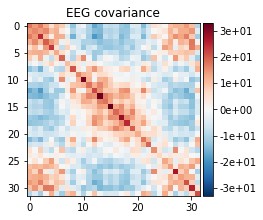

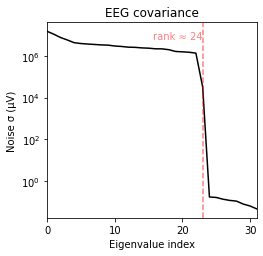

In [7]:
noise_cov = mne.compute_covariance(epochs, tmax=2)

fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, raw.info)

# Var

In [8]:
from mne_connectivity import vector_auto_regression

conn = vector_auto_regression(
    data=epochs.get_data(), times=epochs.times, names=epochs.ch_names)

Loading data for 15 events and 512 original time points ...


100%|██████████| 15/15 [00:00<00:00, 164.83it/s]


Loading data for 15 events and 512 original time points ...
Loading data for 15 events and 512 original time points ...


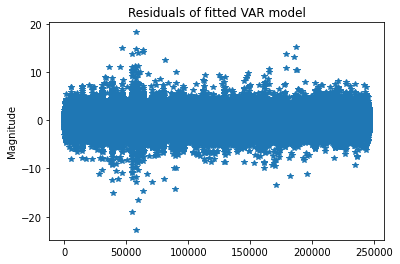

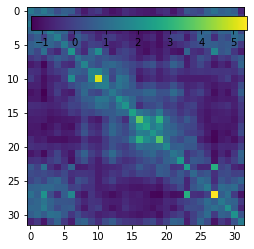

In [9]:
predicted_data = conn.predict(epochs.get_data())

# compute residuals
residuals = epochs.get_data() - predicted_data

# visualize the residuals
fig, ax = plt.subplots()
ax.plot(residuals.flatten(), '*')
ax.set(
    title='Residuals of fitted VAR model',
    ylabel='Magnitude'
)

# compute the covariance of the residuals
model_order = conn.attrs.get('model_order')
t = residuals.shape[0]
sampled_residuals = np.concatenate(
    np.split(residuals[:, :, model_order:], t, 0),
    axis=2
).squeeze(0)
rescov = np.cov(sampled_residuals)

# Next, we visualize the covariance of residuals.
# Here we will see that because we use ordinary
# least-squares as an estimation method, the residuals
# should come with low covariances.
fig, ax = plt.subplots()
cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
im = ax.imshow(rescov, cmap='viridis', aspect='equal', interpolation='none')
fig.colorbar(im, cax=cax, orientation='horizontal')

In [ ]:
conn = vector_auto_regression(
    data=epochs.get_data(), times=epochs.times, names=epochs.ch_names,
    model='avg-epochs')

# this returns a connectivity structure over time
print(conn)

In [ ]:
first_epoch = epochs.get_data()[0, ...]
predicted_data = conn.predict(first_epoch)

# compute residuals
residuals = epochs.get_data() - predicted_data

# visualize the residuals
fig, ax = plt.subplots()
ax.plot(residuals.flatten(), '*')
ax.set(
    title='Residuals of fitted VAR model',
    ylabel='Magnitude'
)

# compute the covariance of the residuals
model_order = conn.attrs.get('model_order')
t = residuals.shape[0]
sampled_residuals = np.concatenate(
    np.split(residuals[:, :, model_order:], t, 0),
    axis=2
).squeeze(0)
rescov = np.cov(sampled_residuals)

# Next, we visualize the covariance of residuals as before.
# Here we will see a similar trend with the covariances as
# with the covariances for time-varying VAR model.
fig, ax = plt.subplots()
cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
im = ax.imshow(rescov, cmap='viridis', aspect='equal', interpolation='none')
fig.colorbar(im, cax=cax, orientation='horizontal')

# Inverse operator

In [6]:
from mne.minimum_norm import make_inverse_operator, apply_inverse
from mne.viz import circular_layout
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle

In [11]:
inverse_operator = make_inverse_operator(epochs.info, fwd, noise_cov,
                                         loose=0.2, depth=0.8)

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 32 channels.
    32 out of 32 channels remain after picking
Selected 32 channels
Creating the depth weighting matrix...
    32 EEG channels
    limit = 20485/20484 = 2.518446
    scale = 60426.8 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 0.018 (2.2e-16 eps * 32 dim * 2.5e+12  max singular value)
    Estimated rank (eeg): 24
    EEG: rank 24 computed from 32 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD 

In [12]:
method = "dSPM"
snr = 3.
lambda2 = 1. / snr ** 2
stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method,
                            pick_ori="normal", return_generator=True)

In [ ]:
import mne
Brain = mne.viz.get_brain_class()

# subjects_dir = mne.datasets.sample.data_path() / 'subjects'
mne.datasets.fetch_hcp_mmp_parcellation(subjects_dir=subjects_dir,
                                        verbose=True)

mne.datasets.fetch_aparc_sub_parcellation(subjects_dir=subjects_dir,
                                          verbose=True)

labels = mne.read_labels_from_annot(
    'fsaverage', 'aparc', 'both', subjects_dir=subjects_dir)

brain = Brain('fsaverage', 'both', 'inflated',  subjects_dir=subjects_dir,
              cortex='low_contrast', background='white', size=(800, 600))
brain.add_annotation('aparc')

In [13]:
# Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
labels = mne.read_labels_from_annot('fsaverage', parc='aparc',
                                    subjects_dir=subjects_dir)
labels.pop(-1)
label_colors = [label.color for label in labels]

# Average the source estimates within each label using sign-flips to reduce
# signal cancellations, also here we return a generator
src = inverse_operator['src']
label_ts = mne.extract_label_time_course(
    stcs, labels, src, mode='mean_flip', return_generator=True)

fmin = (0.5, 4., 8., 13., 30.)
fmax = (4., 8., 13., 30., 45.)
sfreq = raw.info['sfreq']  # the sampling frequency
con_methods = ['pli', 'wpli2_debiased', 'ciplv']
con = spectral_connectivity_epochs(
    label_ts, method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
    fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)

# con is a 3D array, get the connectivity for the first (and only) freq. band
# for each method
con_res = dict()
for method, c in zip(con_methods, con):
    con_res[method] = c.get_data(output='dense')[:, :, 0]

Reading labels from parcellation...
   read 35 labels from C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
Connectivity computation...
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 24 (8 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 32 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 15
Extracting time courses for 68 labels (mode: mean_flip)
only using indices for lower-triangular matrix
    computing connectivity for 2278 connections
    using t=0.000s..1.996s for estimation (512 points)
    computing connectivity for the bands:
     band 1: 0.5Hz..4

C:\Users\work\AppData\Local\Temp/ipykernel_8500/2148884993.py:19: RuntimeWarning: fmin=0.500 Hz corresponds to 1.000 < 5 cycles based on the epoch length 2.000 sec, need at least 10.000 sec epochs or fmin=2.500. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)


Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 2
Processing epoch : 3 / 15
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 15
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 15
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 15
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 15
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 15
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 15
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 15
Extracting time courses for 68 

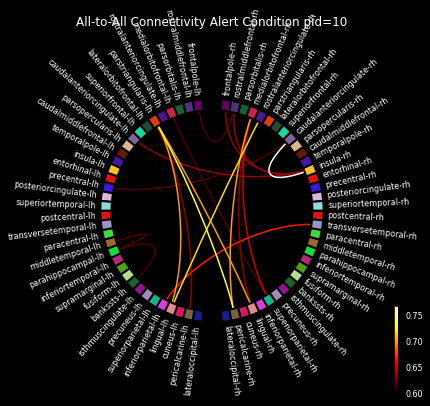

(<Figure size 576x576 with 2 Axes>,
 <PolarAxesSubplot:title={'center':'All-to-All Connectivity Alert Condition pid=10'}>)

In [15]:
# First, we reorder the labels based on their location in the left hemi
label_names = [label.name for label in labels]

lh_labels = [name for name in label_names if name.endswith('lh')]

# Get the y-location of the label
label_ypos = list()
for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

# For the right hemi
rh_labels = [label[:-2] + 'rh' for label in lh_labels]

# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)

node_angles = circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) / 2])

# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
plot_connectivity_circle(con_res['pli'], label_names, n_lines=20,
                         node_angles=node_angles, node_colors=label_colors,
                         title='All-to-All Connectivity Alert Condition pid=10')

ValueError: The number of channels picked (32) does not correspond to the size of the connectivity data (68)

In [ ]:
print(con[0].get_data(output='dense')[:,:,0])

# Run the whole pipeline

### Grab files

In [7]:
mne_data = pd.read_csv("mne_data.csv")

In [8]:
mne_files = mne_data[["al", "fa"]].values.reshape(-1)

In [6]:
mne_files

array(['mne_data/C1_32Ch_48Subjects_al_raw_eeg.fif',
       'mne_data/C1_32Ch_48Subjects_fa_raw_eeg.fif',
       'mne_data/C2_32Ch_48Subjects_al_raw_eeg.fif',
       'mne_data/C2_32Ch_48Subjects_fa_raw_eeg.fif',
       'mne_data/C3_32Ch_48Subjects_al_raw_eeg.fif',
       'mne_data/C3_32Ch_48Subjects_fa_raw_eeg.fif',
       'mne_data/C4_32Ch_48Subjects_al_raw_eeg.fif',
       'mne_data/C4_32Ch_48Subjects_fa_raw_eeg.fif',
       'mne_data/C5_32Ch_48Subjects_al_raw_eeg.fif',
       'mne_data/C5_32Ch_48Subjects_fa_raw_eeg.fif',
       'mne_data/C6_32Ch_48Subjects_al_raw_eeg.fif',
       'mne_data/C6_32Ch_48Subjects_fa_raw_eeg.fif',
       'mne_data/C7_32Ch_48Subjects_al_raw_eeg.fif',
       'mne_data/C7_32Ch_48Subjects_fa_raw_eeg.fif',
       'mne_data/C8_32Ch_48Subjects_al_raw_eeg.fif',
       'mne_data/C8_32Ch_48Subjects_fa_raw_eeg.fif',
       'mne_data/C9_32Ch_48Subjects_al_raw_eeg.fif',
       'mne_data/C9_32Ch_48Subjects_fa_raw_eeg.fif',
       'mne_data/C10_32Ch_48Subjects_al_raw_ee

In [ ]:
raw_list[2].first_samp

In [10]:
# Download fsaverage files
fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)

# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = os.path.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = os.path.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

raw = mne.io.read_raw_fif(mne_files[0], verbose=False)

# Forward solution
# Clean channel names to be able to use a standard 1005 montage
new_names = dict(
    (ch_name,
    ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp'))
    for ch_name in raw.ch_names)
raw.rename_channels(new_names)
# Read and set the EEG electrode locations, which are already in fsaverage's
# space (MNI space) for standard_1020:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)
raw.set_eeg_reference(projection=True, verbose=False)  # needed for inverse modeling

fwd = mne.make_forward_solution(raw.info, trans=trans, src=src,
                            bem=bem, eeg=True, mindist=5.0, verbose=False)

# Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
labels = mne.read_labels_from_annot('fsaverage', parc='aparc',
                                    subjects_dir=subjects_dir, verbose=False)
labels.pop(-1) # remove the unknown label
label_colors = [label.color for label in labels]

fmin = (0.5, 4., 8., 13., 30.)
fmax = (4., 8., 13., 30., 45.)

sfreq = raw.info['sfreq']  # the sampling frequency
con_methods = ['wpli2_debiased']

for mne_filename in mne_files:
    print(f"Running: {mne_filename}")
    # read file and make events
    p_id = mne_filename[10:12].replace("_","")
    if "_al_" in mne_filename: 
        condition = "al"
    elif "_fa_" in mne_filename:
        condition = "fa"
    raw = mne.io.read_raw_fif(mne_filename, verbose=False)

    # for n_raw, raw in enumerate(list_raw):
    events = mne.make_fixed_length_events(raw, start=0., duration=2., overlap=1.5, id = 1)
    
    # Forward solution
    # Clean channel names to be able to use a standard 1005 montage
    new_names = dict(
        (ch_name,
        ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp'))
        for ch_name in raw.ch_names)
    raw.rename_channels(new_names)

    # Read and set the EEG electrode locations, which are already in fsaverage's
    # space (MNI space) for standard_1020:
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)
    raw.set_eeg_reference(projection=True, verbose=False)  # needed for inverse modeling
    
    # fwd = mne.make_forward_solution(raw.info, trans=trans, src=src,
    #                             bem=bem, eeg=True, mindist=5.0, verbose=False)
    
    # make epochs
    event_id = dict(epoch=1)  # event trigger and conditions
    tmin = 0  # start of each epoch
    tmax = 2  # end of each epoch
    baseline = (0, 0)  # means from the first instant to t = 0
    reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                        picks="all", baseline=baseline, verbose=False)
    
    # covariance and inverse operator
    noise_cov = mne.compute_covariance(epochs, tmax=2, verbose=False)
    inverse_operator = make_inverse_operator(epochs.info, fwd, noise_cov,
                                        loose=0.2, depth=0.8, verbose=False)
    
    method = "sLORETA"
    snr = 3.
    lambda2 = 1. / snr ** 2
    stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method,
                                pick_ori="normal", return_generator=True, verbose=False)

    # Average the source estimates within each label using sign-flips to reduce
    # signal cancellations, also here we return a generator
    src = inverse_operator['src']
    label_ts = mne.extract_label_time_course(
        stcs, labels, src, mode='mean_flip', return_generator=True, verbose= False)
    
    con = spectral_connectivity_epochs(
        label_ts, method=con_methods, mode='fourier', sfreq=sfreq, fmin=fmin,
        fmax=fmax, faverage=True, n_jobs=1, verbose=False)

    # con is a 3D array, get the connectivity for the first (and only) freq. band
    # for each method
    output_dir_prefix = "output/no_split3"

    con_values = con.get_data(output='dense')
    for i, f in enumerate(["delta", "theta", "alpha", "beta", "gamma"]):
        con_values_by_freq = con_values[:,:,i]
        np.save(f"{output_dir_prefix}/{p_id}_{condition}_{con_methods[0]}_{f}.npy", con_values_by_freq)


0 files missing from root.txt in C:\Users\work\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage
Running: mne_data/C1_32Ch_48Subjects_al_raw_eeg.fif
Connectivity computation...
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 31 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 32 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 37
Extracting time courses for 68 labels (mode: mean_flip)
only using indices for lower-triangular matrix
    computing connectivity for 2278 connections
    using t=0.000s..2.000s for estimation (513 points)
    computing connectivity for the bands:
     band 1: 1.0Hz..4.0Hz (7 points

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


Processing epoch : 3 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 10
Processing epoch : 11 / 37
Ext

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 37
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 

C:\Users\work\AppData\Local\Temp/ipykernel_4360/3992007394.py:100: RuntimeWarning: fmin=0.500 Hz corresponds to 1.002 < 5 cycles based on the epoch length 2.004 sec, need at least 10.000 sec epochs or fmin=2.495. Spectrum estimate will be unreliable.
  fmax=fmax, faverage=True, n_jobs=1, verbose=False)


Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 2
Processing epoch : 3 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 36
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 36
Extracting time courses for 68 

In [ ]:
mne.make_fixed_length_events(raw, start=0., duration=2., overlap=1.75, id = 1)

# draw

In [3]:
lobe_map = {"Frontal":{
                "frontalpole":"FP",
                "medialorbitofrontal":"MO",
                "lateralorbitofrontal":"LO",
                "paracentral":"ParaC",
                "parsopercularis":"POp",
                "parsorbitalis":"POr",
                "parstriangularis":"PT",
                "precentral": "PreC",
                "rostralanteriorcingulate":"RAC",
                "rostralmiddlefrontal":"RMF",
                "superiorfrontal":"SF",
                "caudalanteriorcingulate":"CACC",
                "caudalmiddlefrontal":"CMF",
            },
            "Parietal":{
                "superiorparietal":"SP",
                "inferiorparietal":"IP",
                "isthmuscingulate":"IC",
                "postcentral":"PG",
                "posteriorcingulate":"PCC",
                "precuneus":"PCUN",
                "supramarginal":"SG",
            },
            "Temporal":{
                "bankssts":"BSTS",
                "entorhinal":"ENT",
                "fusiform":"FUS",
                "middletemporal":"MT",
                "parahippocampal":"PHG",
                "superiortemporal": "STG",
                "temporalpole":"TP",
                "transversetemporal":"TTG",
                "inferiortemporal":"ITG",
            },
            "Occipital":{
                "cuneus":"CUN",
                "lateraloccipital":"LOC",
                "lingual":"LNG",
                "pericalcarine":"PCAL",
            },
            "Insula":{
                "insula":"INS"
            }
}
lobe_map_color = {"Frontal": (1,0,0),
                  "Insula": (0,1,0),
                "Temporal": (0,0,1),
                "Parietal": (1,1,0), 
                 "Occipital": (0,1,1),
}

In [4]:
freqs = ['delta', 'theta', 'alpha', 'beta', 'gamma']
method = 'pli'
output_dir_prefix = "output/no_split"
# condition = "al"

In [5]:
labels = mne.read_labels_from_annot('fsaverage', parc='aparc',
                                            subjects_dir=subjects_dir, verbose=False)
labels.pop(-1) # remove the unknown label
label_names = [label.name for label in labels]

In [6]:
def get_lower_triangle(data):
    """
    get lower part of diagonal matrix
    """
    data_lower = data[np.tril_indices(data.shape[0], k=-1)]
    return data_lower

In [7]:
import glob
import numpy as np
critical_index = np.load("critical_index.npy")
freqs = [ 'delta', 'theta', 'alpha', 'beta', 'gamma']
lh_labels = ['lateraloccipital-lh','pericalcarine-lh','cuneus-lh','lingual-lh',
            'inferiorparietal-lh','superiorparietal-lh','precuneus-lh','isthmuscingulate-lh','supramarginal-lh','postcentral-lh','posteriorcingulate-lh',
            'bankssts-lh','fusiform-lh','inferiortemporal-lh','parahippocampal-lh','middletemporal-lh','transversetemporal-lh','superiortemporal-lh','entorhinal-lh','temporalpole-lh',
            'insula-lh',
            'paracentral-lh','precentral-lh','caudalmiddlefrontal-lh','parsopercularis-lh','caudalanteriorcingulate-lh','superiorfrontal-lh','lateralorbitofrontal-lh','parstriangularis-lh','rostralanteriorcingulate-lh','medialorbitofrontal-lh','parsorbitalis-lh','rostralmiddlefrontal-lh','frontalpole-lh']
rh_labels = [label[:-2] + 'rh' for label in lh_labels]

processing freq:  delta
al_fc_sum shape:  (68, 68)


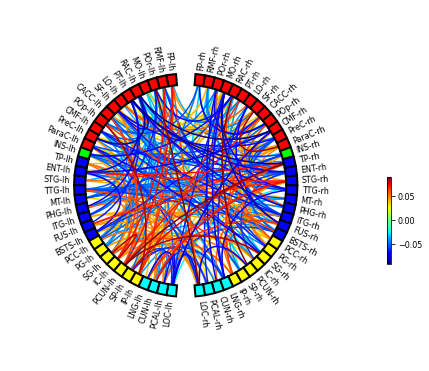

processing freq:  theta
al_fc_sum shape:  (68, 68)


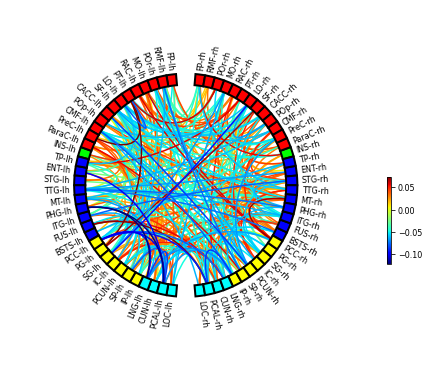

processing freq:  alpha
al_fc_sum shape:  (68, 68)


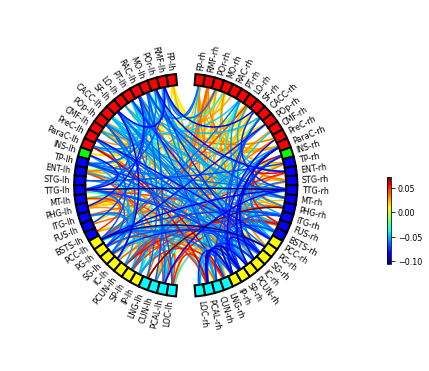

processing freq:  beta
al_fc_sum shape:  (68, 68)


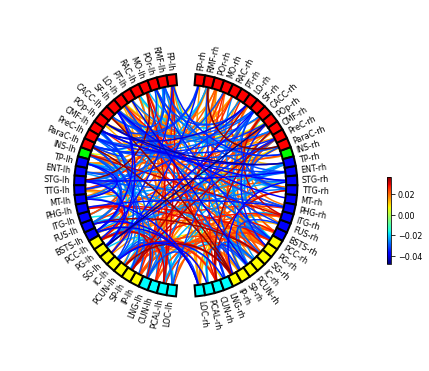

processing freq:  gamma
al_fc_sum shape:  (68, 68)


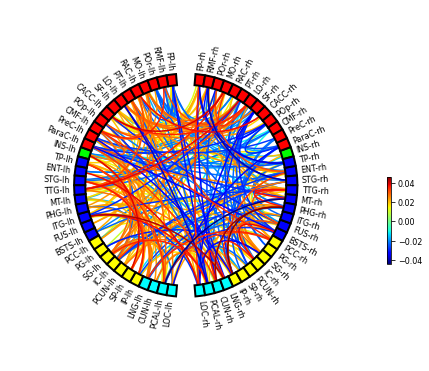

In [11]:
# for condition in ["al", "fa"]:
for i, freq in enumerate(freqs):
    print("processing freq: ", freq)
    al_fc_sum = np.zeros((len(labels), len(labels)))
    fa_fc_sum = np.zeros((len(labels), len(labels)))
    # get all the files
    al_files = glob.glob(f"{output_dir_prefix}/*al*{method}*{freq}*.npy")
    fa_files = glob.glob(f"{output_dir_prefix}/*fa*{method}*{freq}*.npy")
    # print(files)
    for file in al_files:
        al_fc_sum += np.load(file)
    al_fc_sum = al_fc_sum / len(al_files)
    for file in fa_files:
        fa_fc_sum += np.load(file)
    fa_fc_sum = fa_fc_sum / len(fa_files)

    print("al_fc_sum shape: ", al_fc_sum.shape)
    
    al_data = get_lower_triangle(al_fc_sum)
    fa_data = get_lower_triangle(fa_fc_sum)

    al_fa_data = al_data - fa_data
    filtered_data = al_fa_data*critical_index[i]
    tri = np.zeros((68, 68))
    tri[np.tril_indices(68, k=-1)] = filtered_data
    # np.save(f"connection_alter_{freq}.npy", tri)

    # First, we reorder the labels based on their location in the left hemi
    label_colors = []
    label_names = [label.name for label in labels]
    for name in label_names:
        name = name.split("-")[0]
        for lobe in lobe_map:
            if name in list(lobe_map[lobe].keys()):
                label_colors.append(lobe_map_color[lobe])
                break
    
    # get the name in the 
    abbr_names = []
    for l in label_names:
        name = l.split("-")[0]
        h = l.split("-")[1]
        for lobe in lobe_map:
            if name in list(lobe_map[lobe].keys()):
                abbr_names.append(lobe_map[lobe][name] + "-" + h)
                break
    lh_labels_abbr = []
    rh_labels_abbr = []
    for l in lh_labels:
        name = l.split("-")[0]
        h = l.split("-")[1]
        for lobe in lobe_map:
            if name in list(lobe_map[lobe].keys()):
                lh_labels_abbr.append(lobe_map[lobe][name]+ "-lh")
                rh_labels_abbr.append(lobe_map[lobe][name]+ "-rh")
                break
    # Save the plot order and create a circular layout
    node_order = list()
    node_order.extend(lh_labels_abbr[::-1])  # reverse the order
    node_order.extend(rh_labels_abbr)
    node_angles = circular_layout(abbr_names, node_order, start_pos=90,
                                group_boundaries=[0, len(abbr_names) / 2])
    fig = plot_connectivity_circle(tri, abbr_names, n_lines=295,
                            node_angles=node_angles, node_colors=label_colors,
                            facecolor='white', textcolor='black', colormap= 'jet', colorbar_pos=(0.8,0.4))
    fig[0].savefig(f"plot/{freq}.png", dpi=300)
# res.append(list_freq)


In [34]:
# np.save("critical_value.npy", res)